<div class="alert alert-block alert-success"><font color="black"><h1><left>EDA of MIMIC ICU Data for Intestinal Conditions</left></h1></font></div>


In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
# File definitions
path = 'E:\Education\DataScience\CCSU-Data-Science\Data-Mining-And-Predictive-Analytics\Data-531\Data\\'
file1 = path + 'part-00000-diagnosis-code.snappy.parquet'
file2 = path + 'part-00000-admission-diags.snappy.parquet'
file3 = path + 'part-00000-admissions.snappy.parquet'
file4 = path + 'part-00000-note-events.snappy.parquet'
file5 = path + 'part-00000-chart-events.snappy.parquet'
file6 = path + 'part-00000-icu-stays.snappy.parquet'
file8 = path + 'part-00000-procedure-icd-snappy.parquet'
file9 = path + 'notes-12-6.snappy.parquet'
file7 = path + 'ICD10_Formatted.csv'

<div class="alert alert-block alert-success"><font color="black"><h1><left>Generate Core Dataframes</left></h1></font></div>


In [3]:
diag_codes = pd.read_parquet(file1,engine='auto',use_nullable_dtypes=True)
admsn_diags = pd.read_parquet(file2,engine='auto',use_nullable_dtypes=True)
# proc_icd = pd.read_parquet(file8,engine='auto',use_nullable_dtypes=True)
admissions = pd.read_parquet(file3,engine='auto',use_nullable_dtypes=True)\
#             [['hadm_id','subject_id','admittime', 'dischtime','diagnosis']]
# notes = pd.read_parquet(file4,engine='auto',use_nullable_dtypes=True)
# cevents = pd.read_parquet(file5,engine='auto',use_nullable_dtypes=True)


<div class="alert alert-block alert-success"><font color="black"><h2><left>Read ICD9 to ICD10 Translatiion file</left></h2></font></div>


In [4]:
import re

icd9_df = pd.read_csv(file7,sep='|', header=0)
icd9_df['ICD9'] = icd9_df['ICD9'].astype(str).apply(lambda x: re.sub('\.','', x))
icd9_df[1:5]

,ICD9,ICD10,Description
1,0011,A00.1,"Cholera due to Vibrio cholerae 01, biovar eltor"
2,0019,A00.9,"Cholera, unspecified"
3,0020,A01.00,"Typhoid fever, unspecified"
4,0021,A01.1,Paratyphoid fever A


In [5]:
icd9_df.columns = ['icd9', 'icd10', 'description']
icd9_df.rename({'icd9': 'ICD9', 'icd10': 'ICD10' }, axis=1, inplace=True)
icd9_df

,ICD9,ICD10,description
0,0010,A00.0,"Cholera due to Vibrio cholerae 01, biovar chol..."
1,0011,A00.1,"Cholera due to Vibrio cholerae 01, biovar eltor"
2,0019,A00.9,"Cholera, unspecified"
3,0020,A01.00,"Typhoid fever, unspecified"
4,0021,A01.1,Paratyphoid fever A
...,...,...,...
14810,20311,C90.11,Plasma cell leukemia in remission
14811,20312,C90.12,Plasma cell leukemia in relapse
14812,20380,C88.8,Other malignant immunoproliferative diseases
14813,20381,C90.21,Extramedullary plasmacytoma in remission


In [6]:
terms = 'gastro|gastric|celiac|bowel|colitis|intestinal|pseudo-obstruction|crohns|diverticulitis|malabsorption|bowel|ischemia|reflux'

<div class="alert alert-block alert-success"><font color="black"><h1><left>Find Diagnosis Codes for Intestinal Conditions and Find Them on Patient Admissions</left></h1></font>

Identified Daignosis Codes : 135
&emsp;Reported Diagnosis Codes : 85
&emsp;Patients with Those Diagnosis: 10,082
&emsp;Patients with Multiple Diagnosis: 854</div>


In [8]:
# Find admissions based on diagnosis associated with admissions
# It generates a dataframe with subject_id, hadm_id, and a list of icd9 codes
# 447 patients have one diagnoses per admission, 6 patients have 2 diagnoses

# find diagnoses with keywords based on terms
wanted_diags = diag_codes[(diag_codes['long_title'].str.contains(terms))] 
# find admissions with wanted diagnoese codes
temp_folks = pd.merge(wanted_diags, admsn_diags, on='icd9_code')[['subject_id', 'hadm_id', 'icd9_code']]
#find unique set of diag codes found associated with a patient
found_diags = temp_folks[['icd9_code']].drop_duplicates()
# turn a patient's diagnoses codes into a list-column (to accomodate mnre than one) 
intestinal_folks = (temp_folks.groupby(['subject_id', 'hadm_id'])['icd9_code']
                             .apply(list)
                             .reset_index(name='icd9_codes')) 
# Find how many admissions with more than 1 diagnosis code
patients_more_than_one = intestinal_folks[intestinal_folks.icd9_codes.map(len) > 1] 
print('wanted diag count: ', wanted_diags.shape[0], ' intestinal_folks count: ', intestinal_folks.shape[0],
     ' found diags: ', len(found_diags), 'more than 1: ', patients_more_than_one.shape[0])
#print the 1st 20 admissins with more than one diagniosis patients with more than one diagnonis code
patients_more_than_one[1:20]

wanted diag count:  135  intestinal_folks count:  10082  found diags:  85 more than 1:  854


,subject_id,hadm_id,icd9_codes
13,109,126055,"[53081, 78906]"
58,369,145787,"[2713, 5589]"
82,605,149601,"[53641, 53642]"
91,688,197752,"[5569, 53081]"
116,810,168366,"[5589, 5789]"
126,862,186550,"[5583, 53081]"
151,978,182676,"[53081, 53140]"
171,1136,139574,"[5789, 53081]"
182,1223,191339,"[5569, 5789]"
200,1347,197101,"[53081, V160]"


In [9]:
pd.set_option('display.max_rows',50)
found_diags

,icd9_code
0,0030
2,0090
28,0091
47,1763
49,2713
...,...
10910,90221
10915,E8584
10916,86389
10957,86399


<div class="alert alert-block alert-success"><font color="black"><h1><left>Assign Primary ICD9 Diagnosis Code and Translate to ICD10 Code</left></h1></font>

    * Convert icd9-10 conversion table to dictionary
    * Assign primary icd9 and icd10 codes
    * How many have two or more desired diagnosis
    * How many were not assigned an ICD10 code

</div>


In [10]:
import itertools
# icd9_df[1:10]
icd9_dict = dict(zip(icd9_df['ICD9'], icd9_df['ICD10']))
# Get first N items in dictionary
out = dict(itertools.islice(icd9_dict.items(), 10))
         
# printing result
print("Dictionary limited by K is : " + str(out))


Dictionary limited by K is : {'0010': 'A00.0', '0011': 'A00.1', '0019': 'A00.9', '0020': 'A01.00', '0021': 'A01.1', '0022': 'A01.2', '0023': 'A01.3', '0029': 'A01.4', '0030': 'A02.0', '0031': 'A02.1'}


<div class="alert alert-block alert-success"><font color="black"><h1><left>Assign ICD10 Daignosis Code</left></h1></font></div>


In [11]:
import numpy as np

def find_primary(dlist, ddict):
    for diag in dlist:
        if diag in ddict:
            return(diag, ddict[diag])
    return

func1 = np.vectorize(find_primary)


intestinal_folks['primary_icd9_code'],intestinal_folks['primary_icd10_code']\
    = func1(intestinal_folks['icd9_codes'], icd9_dict)


intestinal_folks[intestinal_folks['icd9_codes'].map(len) > 1][1:10]




,subject_id,hadm_id,icd9_codes,primary_icd9_code,primary_icd10_code
13,109,126055,"[53081, 78906]",53081,K21.9
58,369,145787,"[2713, 5589]",2713,E74.39
82,605,149601,"[53641, 53642]",53641,K94.22
91,688,197752,"[5569, 53081]",5569,K51.90
116,810,168366,"[5589, 5789]",5589,K52.9
126,862,186550,"[5583, 53081]",5583,K52.2
151,978,182676,"[53081, 53140]",53081,K21.9
171,1136,139574,"[5789, 53081]",5789,K92.2
182,1223,191339,"[5569, 5789]",5569,K51.90


In [12]:
intestinal_folks.columns

Index(['subject_id', 'hadm_id', 'icd9_codes', 'primary_icd9_code',
       'primary_icd10_code'],
      dtype='object')

<div class="alert alert-block alert-success"><font color="black"><h1><left>Tie Relavent Admissions to Admission Data and Calculate Length of Stay in Hours</left></h1></font>

In [13]:
# Find time in hospital (in hours) stats by diagnosis code
admissions['stay_hours'] = (admissions.dischtime - admissions.admittime).astype('timedelta64[h]')
intestinal_adms = pd.merge(intestinal_folks, admissions, on=['subject_id','hadm_id'])\
                [['subject_id', 'hadm_id', 'icd9_codes', 'primary_icd9_code', 'primary_icd10_code', 'stay_hours', \
                  'admittime', 'dischtime','deathtime',\
                 'admission_type', 'insurance', 'language', 'religion','marital_status', 'ethnicity', 'diagnosis']]
intestinal_adms[1:5]


,subject_id,hadm_id,icd9_codes,primary_icd9_code,primary_icd10_code,stay_hours,admittime,dischtime,deathtime,admission_type,insurance,language,religion,marital_status,ethnicity,diagnosis
1,32,175413,[53081],53081,K21.9,460.0,2170-04-04 08:00:00,2170-04-23 12:45:00,NaT,ELECTIVE,Medicaid,<NA>,UNOBTAINABLE,<NA>,WHITE,TRACHEAL STENOSIS/SDA
2,36,122659,[53081],53081,K21.9,305.0,2131-05-12 19:49:00,2131-05-25 13:30:00,NaT,EMERGENCY,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,CHEST PAIN/SHORTNESS OF BREATH
3,36,182104,[53081],53081,K21.9,198.0,2131-04-30 07:15:00,2131-05-08 14:00:00,NaT,EMERGENCY,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
4,37,188670,[53551],53551,K29.91,122.0,2183-08-21 16:48:00,2183-08-26 18:54:00,NaT,EMERGENCY,Medicare,<NA>,JEWISH,MARRIED,WHITE,CONGESTIVE HEART FAILURE


In [14]:
intestinal_adms.admittime = pd.to_datetime(intestinal_adms.admittime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
intestinal_adms.dischtime = pd.to_datetime(intestinal_adms.dischtime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
intestinal_adms.deathtime = pd.to_datetime(intestinal_adms.deathtime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
intestinal_adms[1:10]

,subject_id,hadm_id,icd9_codes,primary_icd9_code,primary_icd10_code,stay_hours,admittime,dischtime,deathtime,admission_type,insurance,language,religion,marital_status,ethnicity,diagnosis
1,32,175413,[53081],53081,K21.9,460.0,2170-04-04 08:00:00,2170-04-23 12:45:00,NaT,ELECTIVE,Medicaid,<NA>,UNOBTAINABLE,<NA>,WHITE,TRACHEAL STENOSIS/SDA
2,36,122659,[53081],53081,K21.9,305.0,2131-05-12 19:49:00,2131-05-25 13:30:00,NaT,EMERGENCY,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,CHEST PAIN/SHORTNESS OF BREATH
3,36,182104,[53081],53081,K21.9,198.0,2131-04-30 07:15:00,2131-05-08 14:00:00,NaT,EMERGENCY,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
4,37,188670,[53551],53551,K29.91,122.0,2183-08-21 16:48:00,2183-08-26 18:54:00,NaT,EMERGENCY,Medicare,<NA>,JEWISH,MARRIED,WHITE,CONGESTIVE HEART FAILURE
5,53,155385,[53081],53081,K21.9,69.0,2170-03-20 20:20:00,2170-03-23 18:00:00,NaT,EMERGENCY,Private,ENGL,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,MYOCARDIAL INFARCTION\CARDIAC CATH
6,56,181711,[53140],53140,K25.4,152.0,2104-01-02 02:01:00,2104-01-08 10:30:00,2104-01-08 10:30:00,EMERGENCY,Medicare,<NA>,NOT SPECIFIED,<NA>,WHITE,HEAD BLEED
7,75,112086,[53081],53081,K21.9,150.0,2147-04-05 08:00:00,2147-04-11 14:45:00,NaT,ELECTIVE,Medicare,<NA>,CATHOLIC,MARRIED,WHITE,AORTIC STENOSIS\AORTIC VALVE REPLACEMENT/SDA
8,83,158569,[53081],53081,K21.9,170.0,2142-04-01 12:34:00,2142-04-08 14:46:00,NaT,URGENT,Medicare,<NA>,UNOBTAINABLE,MARRIED,UNKNOWN/NOT SPECIFIED,CAROTID STENOSIS
9,85,116630,[53081],53081,K21.9,191.0,2162-03-02 14:04:00,2162-03-10 13:15:00,NaT,EMERGENCY,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,AORTIC STENOSIS\CARDIAC CATH


In [15]:
# find diag dsescription associared with admission
intestinal_adms.loc[0:10,('subject_id', 'hadm_id', 'icd9_codes','diagnosis')]


,subject_id,hadm_id,icd9_codes,diagnosis
0,24,161859,[53081],INTERIOR MYOCARDIAL INFARCTION
1,32,175413,[53081],TRACHEAL STENOSIS/SDA
2,36,122659,[53081],CHEST PAIN/SHORTNESS OF BREATH
3,36,182104,[53081],CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
4,37,188670,[53551],CONGESTIVE HEART FAILURE
5,53,155385,[53081],MYOCARDIAL INFARCTION\CARDIAC CATH
6,56,181711,[53140],HEAD BLEED
7,75,112086,[53081],AORTIC STENOSIS\AORTIC VALVE REPLACEMENT/SDA
8,83,158569,[53081],CAROTID STENOSIS
9,85,116630,[53081],AORTIC STENOSIS\CARDIAC CATH


In [16]:
intestinal_adms.count()

subject_id            10082
hadm_id               10082
icd9_codes            10082
primary_icd9_code     10082
primary_icd10_code    10082
stay_hours            10082
admittime             10082
dischtime             10082
deathtime               991
admission_type        10082
insurance             10082
language               7478
religion              10046
marital_status         9681
ethnicity             10082
diagnosis             10081
dtype: int64

<div class="alert alert-block alert-success"><font color="black"><h1><left>Length of Stay Statistics and Admission Counts By Primary Diagnosis Code</left></h1></font>

In [21]:
intestinal_adms.merge(diag_codes, left_on='primary_icd9_code', right_on='icd9_code')\
                        .groupby(['primary_icd10_code', 'primary_icd9_code' , 'long_title'])\
                        .agg(stay_hrs_min= ('stay_hours','min'),
                             stay_hrs_max= ('stay_hours','max'),
                             stay_hrs_avg= ('stay_hours','mean'),
                             adms_count=('hadm_id','count'))\
                         .round(1)\
                         .sort_values(by=['adms_count'], ascending=False, inplace=False)[1:20]

,,,stay_hrs_min,stay_hrs_max,stay_hrs_avg,adms_count
primary_icd10_code,primary_icd9_code,long_title,,,,
K92.2,5789,"Hemorrhage of gastrointestinal tract, unspecified",-16.0,4060.0,289.9,1322
K29.90,53550,"Unspecified gastritis and gastroduodenitis, wi...",9.0,3048.0,248.8,298
K56.60,5609,Unspecified intestinal obstruction,4.0,4118.0,424.3,261
K51.90,5569,"Ulcerative colitis, unspecified",1.0,3194.0,255.6,243
K25.4,53140,Chronic or unspecified gastric ulcer with hemo...,19.0,2081.0,231.8,231
K58.9,5641,Irritable bowel syndrome,6.0,1873.0,209.7,219
K52.9,5589,Other and unspecified noninfectious gastroente...,6.0,4954.0,319.2,186
K56.69,56089,Other specified intestinal obstruction,4.0,2213.0,454.8,182
K29.91,53551,"Unspecified gastritis and gastroduodenitis, wi...",28.0,1328.0,242.8,129


In [22]:
# Plot stay times for each admision by diagnosis code
pd.set_option('display.max_rows', 30)
intestinal_adms.shape

(10082, 16)

<div class="alert alert-block alert-success"><font color="black"><h2><left>Compare Diagnosis By Length of Stay</left>
</h2></font>

The next three charts depict length of stay by diagnosis. Since there is a wide gap in frequency across diagnosis, 
I grouped the diagnoses by frequency dividing them into across 3 charts</div>

<div class="alert alert-block alert-success"><font color="black"><h2><left>Examine diagnosis code with the largest counts and the largest length of stay</left>
</h2></font>

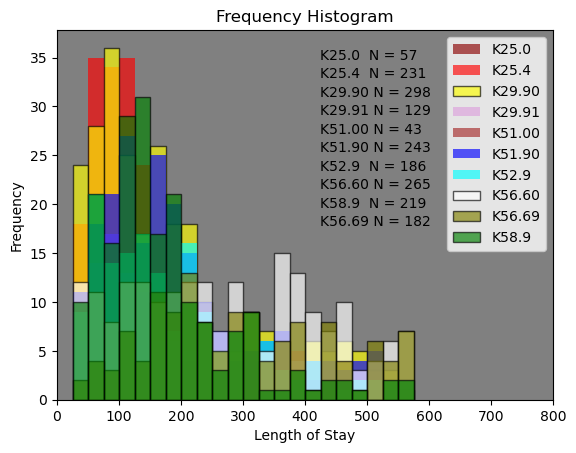

In [17]:
# Plot stay times for each admision by diagnosis code
pd.set_option('display.max_rows', 50)
# intestinal_adms[1:5]
intestinal_adms = intestinal_adms.dropna(subset='primary_icd10_code')
x1 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K25.0'), 'stay_hours']
x2 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K25.4'), 'stay_hours']
x3 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K29.90'), 'stay_hours']
x4 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K29.91'), 'stay_hours']
x5 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K51.00'), 'stay_hours']
x6 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K51.90'), 'stay_hours']
x7 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K52.9'), 'stay_hours']
x8 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K56.60'), 'stay_hours']
x9 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K56.69'), 'stay_hours']
x10 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K58.9'), 'stay_hours']

abins = range(25,600,25)
kwargs = dict(alpha=0.65, bins=abins)
ax = plt.axes(alpha=0)
ax.set_facecolor("grey")
plt.hist(x1, **kwargs, color='darkred', label='K25.0')
plt.hist(x2, **kwargs, color='red', label='K25.4')
plt.hist(x3, **kwargs, color='yellow', edgecolor='black',label='K29.90')
plt.hist(x4, **kwargs, color='plum', label='K29.91')
plt.hist(x5, **kwargs, color='brown', label='K51.00')
plt.hist(x6, **kwargs, color='blue', label='K51.90')
plt.hist(x7, **kwargs, color='cyan', label='K52.9')
plt.hist(x8, **kwargs, color='white', edgecolor='black',label='K56.60')
plt.hist(x9, **kwargs, color='olive', edgecolor='black',label='K56.69')
plt.hist(x10, **kwargs, color='green', edgecolor='black',label='K58.9')


atext = 'K25.0  N = ' + str(len(x1))
btext = 'K25.4  N = ' + str(len(x2))
ctext = 'K29.90 N = ' + str(len(x3))
dtext = 'K29.91 N = ' + str(len(x4))
etext = 'K51.00 N = ' + str(len(x5))
ftext = 'K51.90 N = ' + str(len(x6))
gtext = 'K52.9  N = ' + str(len(x7))
htext = 'K56.60 N = ' + str(len(x8))
itext = 'K56.69 N = ' + str(len(x9))
jtext = 'K58.9  N = ' + str(len(x10))

ax.text(0.53, 0.95,atext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.90, btext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.85, ctext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.80, dtext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.75, etext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.70, ftext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.65, gtext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.60, htext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.55, jtext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.50, itext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)

#plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
#plt.hist(wanted_admissions['stay_hours'], bins=abins)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency', xlabel='Length of Stay');
plt.xlim(0,800)
plt.legend();
# plt.show()

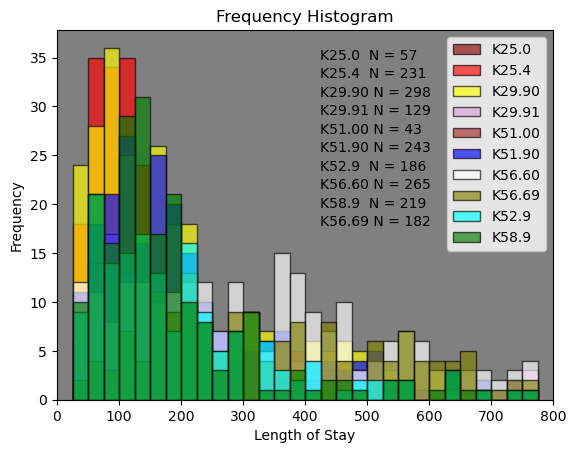

In [18]:
# Plot stay times for each admision by diagnosis code
pd.set_option('display.max_rows', 50)
# intestinal_adms[1:5]
intestinal_adms = intestinal_adms.dropna(subset='primary_icd10_code')

icd_codes2 = {'K25.0':['Acute Gastric Ulcer', 'darkred'],'K25.4':['Unspecified Chronic Gastric Ulcer','red'],
             'K29.90':['Gastroduodenitis','yellow'],'K29.91':['Unspecified Gastritis','plum'],
             'K51.00':['Universal or Chronic Ulcerative Colitis','brown'],'K51.90':['Unspecified Ulcerative Colitis','blue'],
             'K56.60':['Unspecified Intestinal Obstruction','white'], 'K56.69':['Other Specified Intestinal Obstruction','olive'], 
             'K52.9':['Unspecified Gastroenteritis','cyan'],'K58.9':['Iterable Bowel Syndrome','green']}

abins = range(25,800,25)
kwargs = dict(alpha=0.65, bins=abins)
ax = plt.axes(alpha=0)
ax.set_facecolor("grey")

temp_vert = 100

for code, description in icd_codes2.items():
    
    temp_x = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains(code), 'stay_hours']
    ax.hist(temp_x, **kwargs, color=description[1], edgecolor='black', label=code)
    temp_text = ' N = ' + str(len(temp_x))
    temp_vert -= 2
#    ax.text(0.5, temp_vert, temp_text, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)

atext = 'K25.0  N = ' + str(len(x1))
btext = 'K25.4  N = ' + str(len(x2))
ctext = 'K29.90 N = ' + str(len(x3))
dtext = 'K29.91 N = ' + str(len(x4))
etext = 'K51.00 N = ' + str(len(x5))
ftext = 'K51.90 N = ' + str(len(x6))
gtext = 'K52.9  N = ' + str(len(x7))
htext = 'K56.60 N = ' + str(len(x8))
itext = 'K56.69 N = ' + str(len(x9))
jtext = 'K58.9  N = ' + str(len(x10))

ax.text(0.53, 0.95,atext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.90, btext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.85, ctext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.80, dtext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.75, etext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.70, ftext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.65, gtext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.60, htext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.55, jtext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.50, itext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)

plt.gca().set(title='Frequency Histogram', ylabel='Frequency', xlabel='Length of Stay');
plt.xlim(0,800)
plt.legend();
plt.show()

In [23]:
intestinal_adms.shape

(10082, 16)

<div class="alert alert-block alert-success"><font color="black"><h2><left>Examine Largest Diagnosis Codes in Side-By-Side Charts</left>
</h2></font>

Text(0.5, 1.0, 'K58.9 Iterable Bowel Syndrome')

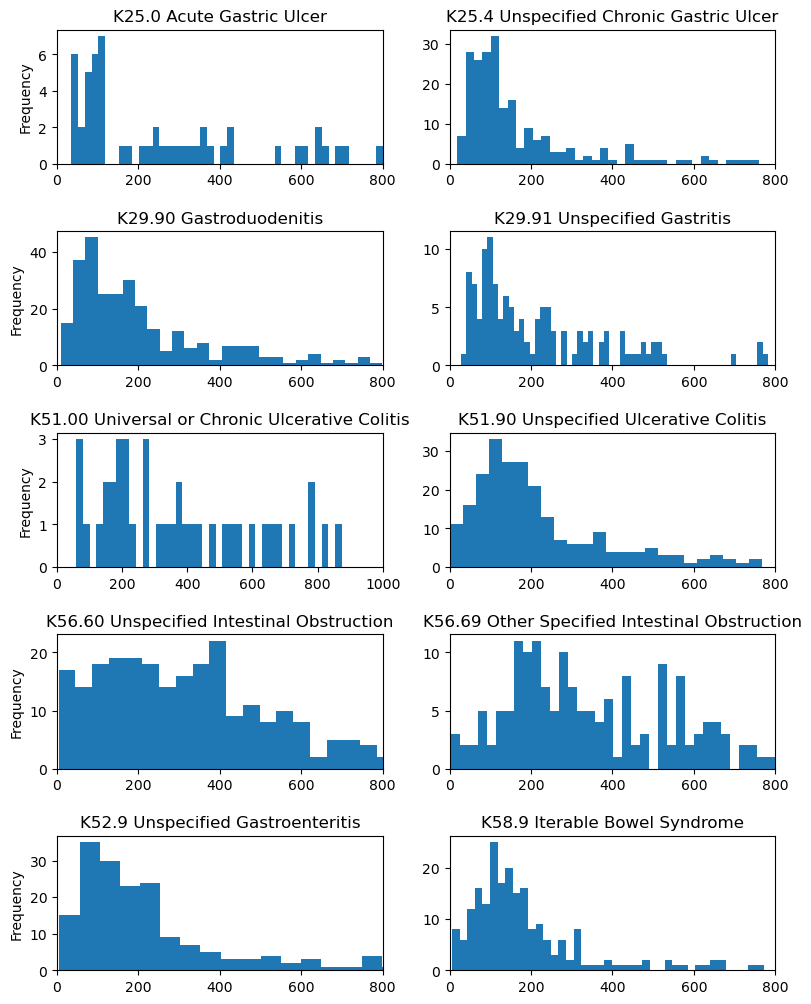

In [160]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
abins = range(25,600,25)
kwargs = dict(alpha=0.65, bins=abins)

axis[0,0].hist(x1,bins=100)
axis[0,0].set_xlim(0,800)
axis[0,0].set_title("K25.0 Acute Gastric Ulcer")
axis[0,0].set_ylabel('Frequency')

axis[0,1].hist(x2,bins=100)
axis[0,1].set_xlim(0,800)
axis[0,1].set_title("K25.4 Unspecified Chronic Gastric Ulcer")
# axis[3,0].set_ylabel('Frequency')

axis[1,0].hist(x3,bins=100)
axis[1,0].set_xlim(0,800)
axis[1,0].set_title("K29.90 Gastroduodenitis")
axis[1,0].set_ylabel('Frequency')

axis[1,1].hist(x4,bins=100)
axis[1,1].set_xlim(0,800)
axis[1,1].set_title("K29.91 Unspecified Gastritis")
# axis[0,1].set_ylabel('Frequency')

axis[2,0].hist(x5,bins=100)
axis[2,0].set_xlim(0,1000)
axis[2,0].set_title("K51.00 Universal or Chronic Ulcerative Colitis")
axis[2,0].set_ylabel('Frequency')

axis[2,1].hist(x6,bins=100)
axis[2,1].set_xlim(0,800)
axis[2,1].set_title("K51.90 Unspecified Ulcerative Colitis")
# axis[2,0].set_ylabel('Frequency'),bins=100

axis[3,0].hist(x8,bins=100)
axis[3,0].set_xlim(0,800)
axis[3,0].set_title("K56.60 Unspecified Intestinal Obstruction")
axis[3,0].set_ylabel('Frequency')

axis[3,1].hist(x9,bins=100)
axis[3,1].set_xlim(0,800)
axis[3,1].set_title("K56.69 Other Specified Intestinal Obstruction")
# axis[1,1].set_ylabel('Frequency')

axis[4,0].hist(x7,bins=100)
axis[4,0].set_xlim(0,800)
axis[4,0].set_title("K52.9 Unspecified Gastroenteritis")
axis[4,0].set_ylabel('Frequency')

axis[4,1].hist(x10,bins=100)
axis[4,1].set_xlim(0,800)
axis[4,1].set_title("K58.9 Iterable Bowel Syndrome")
# axis[3,1].set_ylabel('Frequency')

<div class="alert alert-block alert-success"><font color="black"><h2><left>Simplify Side-By-Side Charts Logic</left>
</h2></font>

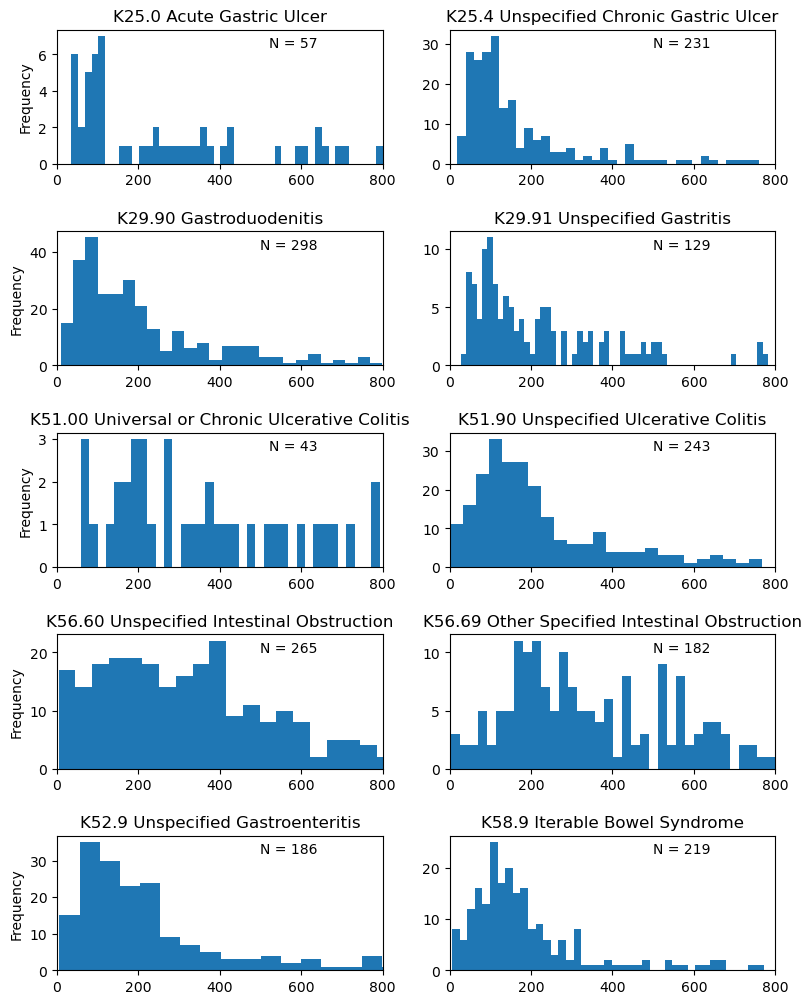

In [19]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
abins = range(25,600,25)
kwargs = dict(alpha=0.65, bins=abins)



icd_codes = {'K25.0':'Acute Gastric Ulcer','K25.4':'Unspecified Chronic Gastric Ulcer',
             'K29.90':'Gastroduodenitis','K29.91':'Unspecified Gastritis',
             'K51.00':'Universal or Chronic Ulcerative Colitis','K51.90':'Unspecified Ulcerative Colitis',
             'K56.60':'Unspecified Intestinal Obstruction', 'K56.69':'Other Specified Intestinal Obstruction', 
             'K52.9':'Unspecified Gastroenteritis','K58.9':'Iterable Bowel Syndrome'}

x_row = 0
x_col = 0

for code, description in icd_codes.items():
    
    temp_x = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains(code), 'stay_hours']
    
    atext = 'N = ' + str(len(temp_x))
    axis[x_row,x_col].hist(temp_x, bins=100)
    axis[x_row,x_col].set_xlim(0,800)
    xtitle = code + ' ' + description
    axis[x_row,x_col].text(0.8, 0.95, atext, horizontalalignment='right', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].set_title(xtitle)
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Frequency')
        x_col += 1
    else:
        x_row += 1
        x_col = 0
        
        

<div class="alert alert-block alert-success"><font color="black"><h2><left>Examine Largest Diagnosis Codes Boxplots</left>
</h2></font>

[Text(0, 1, 'Acute Gastric Ulcer'),
 Text(0, 2, 'Unspecified Chronic Gastric Ulcer'),
 Text(0, 3, 'Gastroduodenitis'),
 Text(0, 4, 'Unspecified Gastritis'),
 Text(0, 5, 'Universal or Chronic Ulcerative Colitis'),
 Text(0, 6, 'Unspecified Ulcerative Colitis'),
 Text(0, 7, 'Unspecified Intestinal Obstruction'),
 Text(0, 8, 'Other Specified Intestinal Obstruction'),
 Text(0, 9, 'Unspecified Gastroenteritis'),
 Text(0, 10, 'Iterable Bowel Syndrome')]

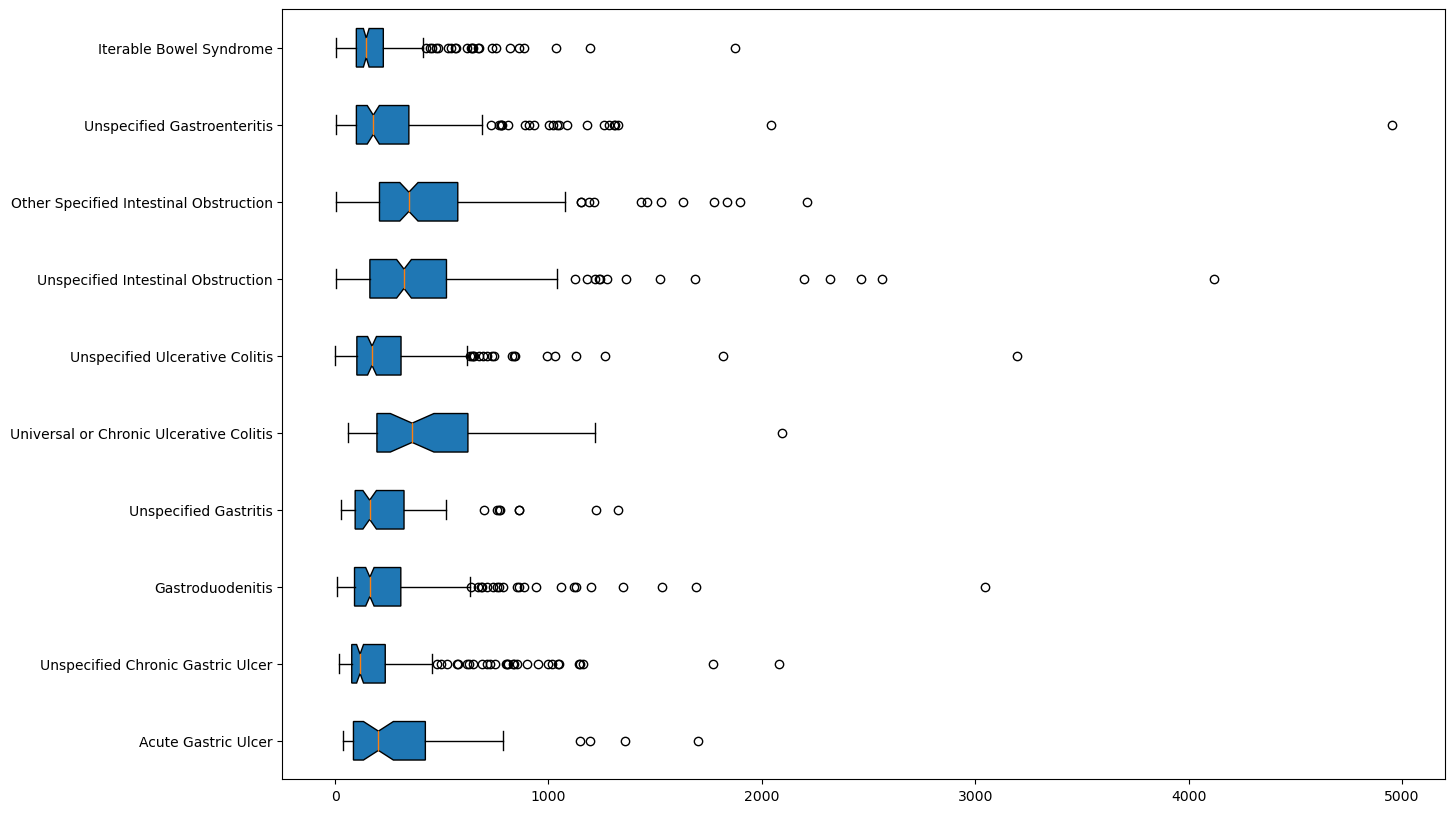

In [20]:

fig = plt.figure(figsize =(15, 10))
ax = fig.add_subplot(111)
 
def get_data(code):
    
    temp_x = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains(code), 'stay_hours']
    return temp_x

icd_codes = {'K25.0':'Acute Gastric Ulcer','K25.4':'Unspecified Chronic Gastric Ulcer',
             'K29.90':'Gastroduodenitis','K29.91':'Unspecified Gastritis',
             'K51.00':'Universal or Chronic Ulcerative Colitis','K51.90':'Unspecified Ulcerative Colitis',
             'K56.60':'Unspecified Intestinal Obstruction', 'K56.69':'Other Specified Intestinal Obstruction', 
             'K52.9':'Unspecified Gastroenteritis','K58.9':'Iterable Bowel Syndrome'}


x_data = []
x_description = []
x_items = 0

for code, description in icd_codes.items():
    
    x_description.append(description)
    x_data.append(get_data(code))
    

# Creating axes instance
bp = ax.boxplot(x_data, patch_artist = True,
                notch ='True', vert = 0)

ax.set_yticklabels(x_description)



In [21]:
#intestinal_adms.columns
ethnicity_adms = intestinal_adms[['ethnicity','primary_icd10_code']].groupby(['ethnicity','primary_icd10_code'])\
                                                                    .size().reset_index(name='Total')\
                                                                    .sort_values('Total', ascending=False)
#df.groupby(["Group", "Size"]).size().reset_index(name="Time").sort_values()
ethnicity_adms

,ethnicity,primary_icd10_code,Total
302,WHITE,K21.9,4417
336,WHITE,K92.2,946
71,BLACK/AFRICAN AMERICAN,K21.9,531
267,UNKNOWN/NOT SPECIFIED,K21.9,336
321,WHITE,K51.90,212
...,...,...,...
176,HISPANIC/LATINO - PUERTO RICAN,K94.23,1
178,HISPANIC/LATINO - PUERTO RICAN,R10.13,1
179,HISPANIC/LATINO - PUERTO RICAN,Z43.1,1
180,HISPANIC/LATINO - PUERTO RICAN,Z80.0,1


<div class="alert alert-block alert-success"><font color="black"><h2><left>Compare the LOS for Emergency vs Elective</left>
</h2></font>

35

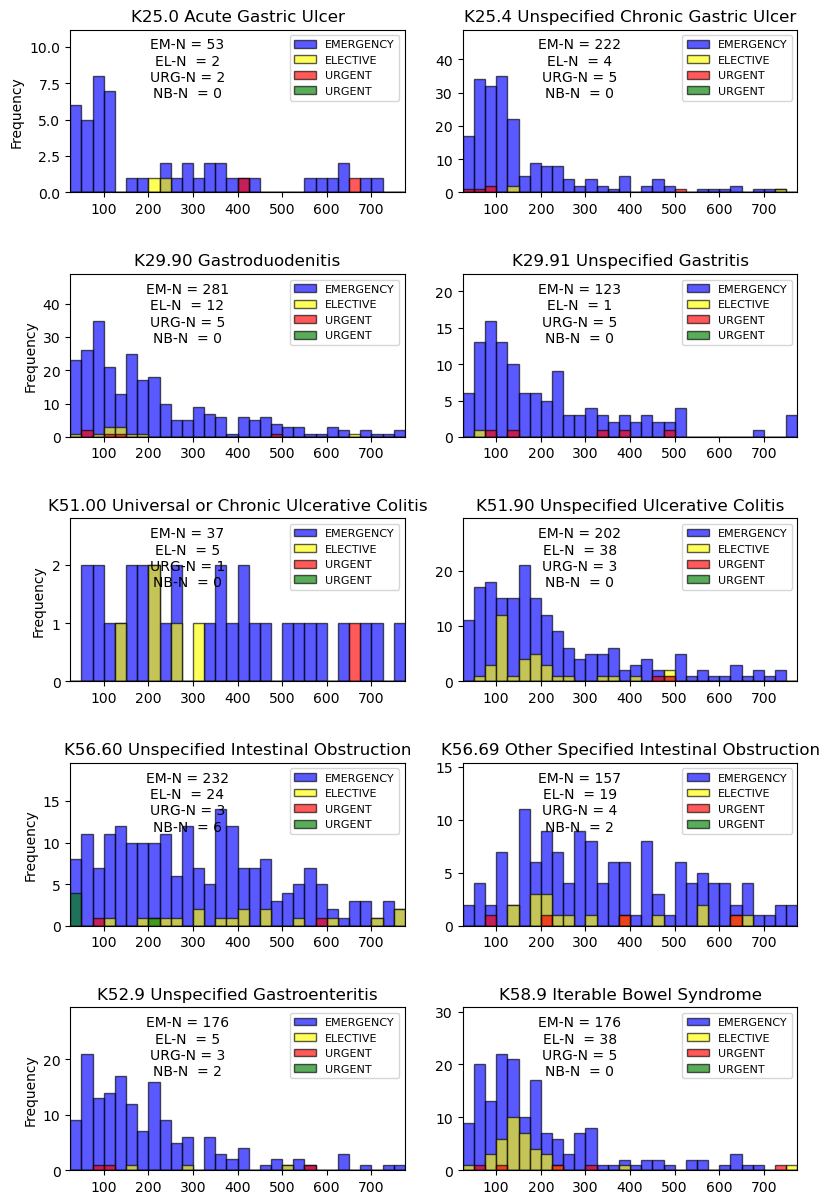

In [38]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(nrows=5, ncols=2, figsize=(8, 12))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
abins = range(25,800,25)
kwargs = dict(alpha=0.65, bins=abins)


icd_codes = {'K25.0':'Acute Gastric Ulcer','K25.4':'Unspecified Chronic Gastric Ulcer',
             'K29.90':'Gastroduodenitis','K29.91':'Unspecified Gastritis',
             'K51.00':'Universal or Chronic Ulcerative Colitis','K51.90':'Unspecified Ulcerative Colitis',
             'K56.60':'Unspecified Intestinal Obstruction', 'K56.69':'Other Specified Intestinal Obstruction', 
             'K52.9':'Unspecified Gastroenteritis','K58.9':'Iterable Bowel Syndrome'}

x_row = 0
x_col = 0

for code, description in icd_codes.items():
    
    xem = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
    (intestinal_adms['admission_type'] == 'EMERGENCY'),'stay_hours']
    xel = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
    (intestinal_adms['admission_type'] == 'ELECTIVE'),'stay_hours']
    xur = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
    (intestinal_adms['admission_type'] == 'URGENT'),'stay_hours']
    xnb = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
    (intestinal_adms['admission_type'] == 'NEWBORN'),'stay_hours']

    atext = 'EM-N = ' + str(len(xem))
    btext = 'EL-N  = ' + str(len(xel))
    ctext = 'URG-N = ' + str(len(xur))
    dtext = 'NB-N  = ' + str(len(xnb))
    
    axis[x_row,x_col].hist(xem, **kwargs, color='blue', edgecolor='black',label='EMERGENCY')
    axis[x_row,x_col].hist(xel, **kwargs, color='yellow', edgecolor='black',label='ELECTIVE')
    axis[x_row,x_col].hist(xur, **kwargs, color='red', edgecolor='black',label='URGENT')
    axis[x_row,x_col].hist(xnb, **kwargs, color='green', edgecolor='black',label='URGENT')
    xtitle = code + ' ' + description
    axis[x_row,x_col].text(0.35, 0.95, atext, horizontalalignment='center', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.35, 0.85, btext, horizontalalignment='center', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.35, 0.75, ctext, horizontalalignment='center', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.35, 0.65, dtext, horizontalalignment='center', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    
    axis[x_row,x_col].legend(fontsize="8")
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].margins(0,0.40)    
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Frequency')
        x_col += 1
    else:
        x_row += 1
        x_col = 0
    
35

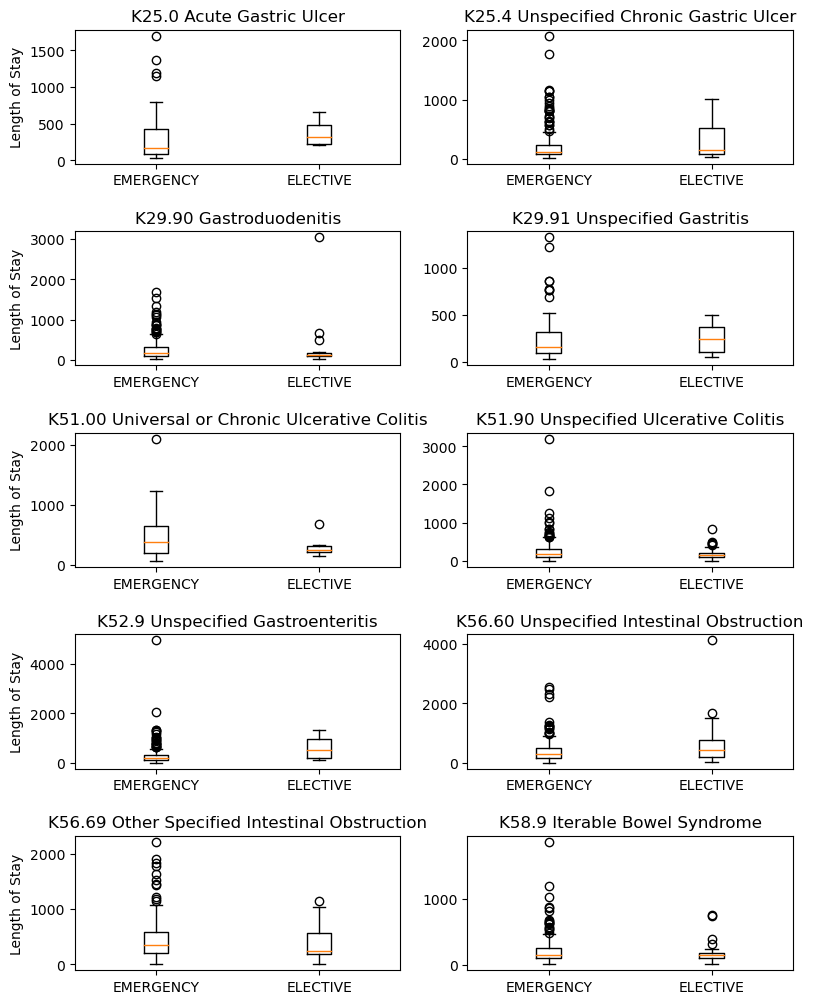

In [168]:
figure, axis = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
# abins = range(25,800,25)
# kwargs = dict(alpha=0.65, bins=abins)



icd_codes = {'K25.0':'Acute Gastric Ulcer','K25.4':'Unspecified Chronic Gastric Ulcer',
             'K29.90':'Gastroduodenitis','K29.91':'Unspecified Gastritis',
             'K51.00':'Universal or Chronic Ulcerative Colitis','K51.90':'Unspecified Ulcerative Colitis',
             'K52.9':'Unspecified Gastroenteritis','K56.60':'Unspecified Intestinal Obstruction', 
             'K56.69':'Other Specified Intestinal Obstruction', 'K58.9':'Iterable Bowel Syndrome'}

x_row = 0
x_col = 0

for code, description in icd_codes.items():
    
    temp_xm = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
                        (intestinal_adms['admission_type'] == 'EMERGENCY'),'stay_hours']
    temp_xs = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
                        (intestinal_adms['admission_type'] != 'EMERGENCY'),'stay_hours']
    temp_data = [temp_xm, temp_xs]
    axis[x_row,x_col].boxplot(temp_data)
    xtitle = code + ' ' + description
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].set_xticklabels(['EMERGENCY', 'ELECTIVE'])
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Length of Stay')
        x_col += 1
    else:
        x_row += 1
        x_col = 0


In [24]:
def set_ethnic_group(ethnicity):
    if 'WHITE' in ethnicity:
        return 'W'
    elif 'BLACK' in ethnicity:
        return 'B'
    elif 'UNKNOWN' in ethnicity:
        return 'U'
    elif 'DECLINE' in ethnicity:
        return 'U'
    elif 'UNABLE' in ethnicity:
        return 'U'
    elif 'ASIAN' in ethnicity:
        return 'A'
    elif 'HISPANIC' in ethnicity:
        return 'H'
    elif 'NATIVE' in ethnicity:
        return 'I'
    elif 'CARIBBEAN' in ethnicity:
        return 'I'
    elif 'AMERICAN INDIAN' in ethnicity:
        return 'I'
    elif 'PORTUGUESE' in ethnicity:
        return 'W'
    elif 'MIDDLE EASTERN' in ethnicity:
        return 'M'
    elif 'SOUTH AMERICAN' in ethnicity:
        return 'W'
    else:
        return 'O'


# df['add'] = df.apply(lambda row : add(row['A'], row['B'], row['C']), axis = 1)    
intestinal_adms['ethnic_group'] = intestinal_adms.apply(lambda row: set_ethnic_group(row['ethnicity']), axis = 1)


In [26]:
intestinal_adms.shape 

(10082, 17)

In [25]:
intestinal_adms.groupby(['ethnic_group','ethnicity'])['hadm_id'].count() 

ethnic_group  ethnicity                                        
A             ASIAN                                                 126
              ASIAN - ASIAN INDIAN                                   16
              ASIAN - CAMBODIAN                                       4
              ASIAN - CHINESE                                        41
              ASIAN - FILIPINO                                        2
              ASIAN - JAPANESE                                        2
              ASIAN - KOREAN                                          1
              ASIAN - OTHER                                           4
              ASIAN - THAI                                            1
              ASIAN - VIETNAMESE                                     11
B             BLACK/AFRICAN                                           7
              BLACK/AFRICAN AMERICAN                                912
              BLACK/CAPE VERDEAN                                     29


In [26]:
# Testing Ethnicity
ethnicity_adms = intestinal_adms.groupby('ethnic_group').size().reset_index(name='Total')\
                                                        .sort_values('Total', ascending=False)
ethnicity_adms

#temp_xm = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
#                        (intestinal_adms['admission_type'] == 'WHITE'),'stay_hours']
#temp_xs = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
#                        (intestinal_adms['admission_type'] != 'WHITE'),'stay_hours']


,ethnic_group,Total
7,W,7541
1,B,971
6,U,784
2,H,346
5,O,215
0,A,208
3,I,12
4,M,5


35

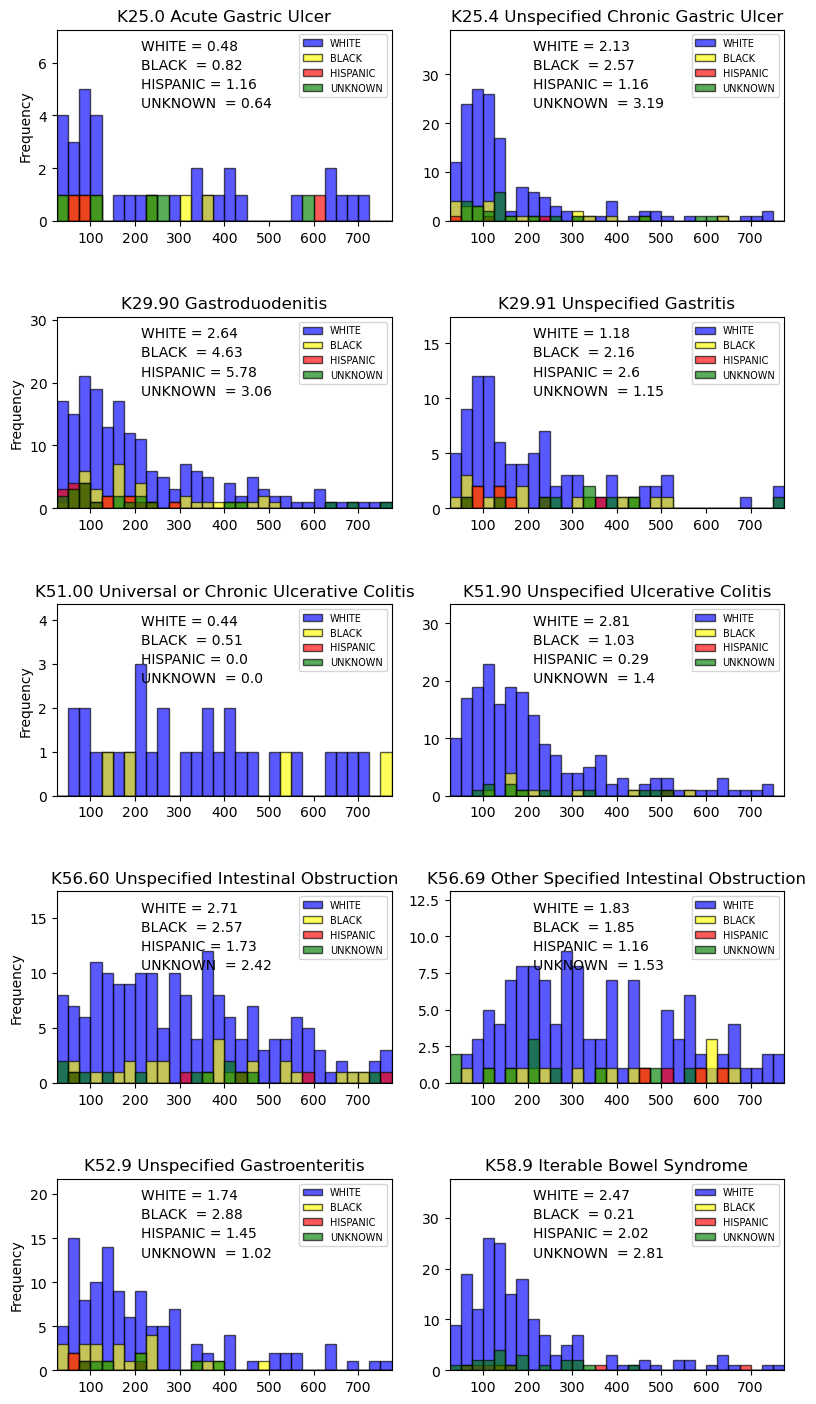

In [27]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(nrows=5, ncols=2, figsize=(8, 14))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
abins = range(25,800,25)
kwargs = dict(alpha=0.65, bins=abins)

icd_codes = {'K25.0':'Acute Gastric Ulcer','K25.4':'Unspecified Chronic Gastric Ulcer',
             'K29.90':'Gastroduodenitis','K29.91':'Unspecified Gastritis',
             'K51.00':'Universal or Chronic Ulcerative Colitis','K51.90':'Unspecified Ulcerative Colitis',
             'K56.60':'Unspecified Intestinal Obstruction', 'K56.69':'Other Specified Intestinal Obstruction', 
             'K52.9':'Unspecified Gastroenteritis','K58.9':'Iterable Bowel Syndrome'}

x_row = 0
x_col = 0

for code, description in icd_codes.items():
        
    temp_xw = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'W'),'stay_hours']
    temp_xb = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'B'),'stay_hours']
    temp_xh = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'H'),'stay_hours']
    temp_xu = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'U'),'stay_hours']
  #  temp_xo = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
  #                      (intestinal_adms['ethnic_group'] in ['O','A','I','M']),'stay_hours']
    
    wn = len(temp_xw)
    bn = len(temp_xb)
    hn = len(temp_xh)
    un = len(temp_xu)
  #  on = len(temp_xo)
    
    twn = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'W')])
    tbn = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'B')])
    thn = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'H')])
    tun = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'U')])
     
    atext = 'WHITE = ' + str(round((len(temp_xw)/twn)*100,2))
    btext = 'BLACK  = ' + str(round((len(temp_xb)/tbn)*100,2))
    ctext = 'HISPANIC = ' + str(round((len(temp_xh)/thn)*100,2))
    dtext = 'UNKNOWN  = ' + str(round((len(temp_xu)/tun)*100,2))
 #   etext = 'OTHER = ' + str(len(temp_xo))
    
     
    axis[x_row,x_col].hist(temp_xw, **kwargs, color='blue', edgecolor='black',label='WHITE')
    axis[x_row,x_col].hist(temp_xb, **kwargs, color='yellow', edgecolor='black',label='BLACK')
    axis[x_row,x_col].hist(temp_xh, **kwargs, color='red', edgecolor='black',label='HISPANIC')
    axis[x_row,x_col].hist(temp_xu, **kwargs, color='green', edgecolor='black',label='UNKNOWN')
   # axis[x_row,x_col].hist(temp_xo, **kwargs, color='purple', edgecolor='black',label='OTHER')
    xtitle = code + ' ' + description
    axis[x_row,x_col].text(0.25, 0.95, atext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.25, 0.85, btext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.25, 0.75, ctext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.25, 0.65, dtext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    # axis[x_row,x_col].text(0.35, 0.55, etext, horizontalalignment='center', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    
    axis[x_row,x_col].legend(fontsize="7")
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].margins(0,0.45)    
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Frequency')
        x_col += 1
    else:
        x_row += 1
        x_col = 0
    
35

In [28]:
# patients with more than one admission
# 10% intestinal folks have more than one admission
gt2admin = intestinal_adms.groupby(['subject_id', ])['hadm_id'].count() \
              .reset_index(name='count') \
              .sort_values(['count'], ascending=False)

counts = gt2admin.loc[gt2admin['count'] > 1]['count']
print('totals: ', sum(gt2admin['count']), ' number: ', len(counts))

totals:  10082  number:  1037


In [29]:
# Count admissions by primary diagnosis
icd10_counts = intestinal_adms.groupby(['primary_icd10_code','primary_icd9_code'])['hadm_id'].count() \
              .reset_index(name='count') \
              .sort_values(['count'], ascending=False)
icd10_count_details = pd.merge(icd10_counts, diag_codes, left_on='primary_icd9_code', right_on='icd9_code',)\
                      [['primary_icd10_code', 'icd9_code', 'long_title', 'count']]
print('total admissions: ', sum(icd10_count_details['count']), ' total codes: ', icd10_count_details.shape[0])
icd10_count_details[1:20]

total admissions:  10082  total codes:  79


,primary_icd10_code,icd9_code,long_title,count
1,K92.2,5789,"Hemorrhage of gastrointestinal tract, unspecified",1322
2,K29.90,53550,"Unspecified gastritis and gastroduodenitis, wi...",298
3,K56.60,5609,Unspecified intestinal obstruction,261
4,K51.90,5569,"Ulcerative colitis, unspecified",243
5,K25.4,53140,Chronic or unspecified gastric ulcer with hemo...,231
6,K58.9,5641,Irritable bowel syndrome,219
7,K52.9,5589,Other and unspecified noninfectious gastroente...,186
8,K56.69,56089,Other specified intestinal obstruction,182
9,K29.91,53551,"Unspecified gastritis and gastroduodenitis, wi...",129
10,I67.848,4359,Unspecified transient cerebral ischemia,95


In [29]:
wanted_icd10_codes = ['K25.0','K25.4','K29.90','K29.91','K51.00','K51.90','K56.60', 'K56.69','K52.9','K58.9']
spec_intel_adms = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].isin(wanted_icd10_codes)]
len(spec_intel_adms)

1853

<div class="alert alert-block alert-success"><font color="black"><h1><left>
Combine Notes and Add to Admissions for the Intestinal Conditions</left></h1></font></div>

In [30]:
def combine_notes(notes):
# This function combine all the individual notes on an admission into one note
    temp_note = ' '
    new_ct = 0
    for note in notes:
        new_ct += 1
 #      print('new_ct: ', new_ct, 'note: ', note[0:20])
        temp_note += note
 #   print('out_length: ', len(temp_note))
    return temp_note


# Read in Notes and Join wanted_admissions with notes
# 
notes = pd.read_parquet(file4,engine='auto',use_nullable_dtypes=True)

sel_categories = ['Nursing/other', 'Nursing', 'Physician']
pn_notes = notes.loc[notes['category'].isin(sel_categories)]
pn_notes[1:5]

pn_full_notes = pn_notes[['subject_id','hadm_id','text']].groupby(['subject_id','hadm_id'],as_index=False)\
                                .agg({'text': combine_notes}).reset_index()
pn_full_notes['note_length'] = pn_full_notes['text'].apply(len)

intsl_notes = pd.merge(spec_intel_amds, pn_full_notes, on=['subject_id', 'hadm_id'])

intsl_notes.columns
intsl_notes[1:10]

,subject_id,hadm_id,icd9_codes,primary_icd9_code,primary_icd10_code,stay_hours,admittime,dischtime,deathtime,admission_type,insurance,language,religion,marital_status,ethnicity,diagnosis,ethnic_group,index,text,note_length
1,56,181711,[53140],53140,K25.4,152.0,2104-01-02 02:01:00,2104-01-08 10:30:00,2104-01-08 10:30:00,EMERGENCY,Medicare,<NA>,NOT SPECIFIED,<NA>,WHITE,HEAD BLEED,W,52,NSG Admit noteB: Please refer to careview and...,5269
2,91,121205,[53100],53100,K25.0,423.0,2177-04-23 00:08:00,2177-05-10 15:16:00,2177-05-10 15:16:00,EMERGENCY,Medicare,<NA>,JEWISH,MARRIED,WHITE,FEVER,W,87,SICU ADMISSION NOTE 230-730 PT IS A 81YO FE...,16161
3,109,102024,"[5609, 53140]",5609,K56.60,387.0,2142-05-20 12:59:00,2142-06-05 16:18:00,NaT,EMERGENCY,Medicaid,ENGL,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,ABDOMINAL PAIN,B,108,Pt is a 24 yo F well known to [**Hospital1 54...,46316
4,109,173633,[5589],5589,K52.9,159.0,2141-12-08 01:40:00,2141-12-14 17:16:00,NaT,EMERGENCY,Medicaid,ENGL,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,ABDOMINAL PAIN,B,134,Ms [**Known lastname 406**] is a 24 year old ...,30467
5,112,174105,[53100],53100,K25.0,118.0,2194-06-13 18:39:00,2194-06-18 16:50:00,NaT,EMERGENCY,Medicare,<NA>,JEWISH,MARRIED,WHITE,GASTROINTESTINAL BLEED,W,145,NURSING MICU NOTE 7P-7A PT [**Name (NI) 577*...,1647
6,124,138376,[56089],56089,K56.69,756.0,2165-12-31 18:55:00,2166-02-01 06:55:00,2166-02-01 06:55:00,EMERGENCY,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,PNEUMONIA;CHRONIC OBST PULM DISEASE,W,159,s/p sub-total colectomy with ileostomy [**1-9...,141021
7,162,195893,[53140],53140,K25.4,71.0,2142-03-25 14:39:00,2142-03-28 13:48:00,NaT,EMERGENCY,Medicare,<NA>,CATHOLIC,SINGLE,WHITE,UPPER GI BLEED,W,205,ADMISSION NOTE: 88 Y.O FEMALE BEING ADMI...,2996
8,178,196159,[5569],5569,K51.90,195.0,2163-01-07 07:15:00,2163-01-15 10:30:00,NaT,ELECTIVE,Private,<NA>,JEWISH,MARRIED,WHITE,MIDLINE HERNIA/SDA,W,222,RESP CARE Pt arrived from or and placed on a ...,2181
9,188,191517,[5589],5589,K52.9,74.0,2157-03-07 11:08:00,2157-03-10 13:50:00,NaT,EMERGENCY,Private,ENGL,CATHOLIC,MARRIED,WHITE,SEPSIS,W,235,Adm from ER this morning with SBP 60-70's on ...,2459


In [181]:
intsl_notes[0:5]

,subject_id,hadm_id,icd9_codes,primary_icd9_code,primary_icd10_code,stay_hours,admittime,dischtime,deathtime,admission_type,insurance,language,religion,marital_status,ethnicity,diagnosis,ethnic_group,index,text,note_length
0,37,188670,[53551],53551,K29.91,122.0,2183-08-21 16:48:00,2183-08-26 18:54:00,NaT,EMERGENCY,Medicare,<NA>,JEWISH,MARRIED,WHITE,CONGESTIVE HEART FAILURE,W,36,Nursing Admission Note 0700-1900. Pt transfer...,2673
1,56,181711,[53140],53140,K25.4,152.0,2104-01-02 02:01:00,2104-01-08 10:30:00,2104-01-08 10:30:00,EMERGENCY,Medicare,<NA>,NOT SPECIFIED,<NA>,WHITE,HEAD BLEED,W,52,NSG Admit noteB: Please refer to careview and...,5269
2,91,121205,[53100],53100,K25.0,423.0,2177-04-23 00:08:00,2177-05-10 15:16:00,2177-05-10 15:16:00,EMERGENCY,Medicare,<NA>,JEWISH,MARRIED,WHITE,FEVER,W,87,SICU ADMISSION NOTE 230-730 PT IS A 81YO FE...,16161
3,109,102024,"[5609, 53140]",5609,K56.60,387.0,2142-05-20 12:59:00,2142-06-05 16:18:00,NaT,EMERGENCY,Medicaid,ENGL,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,ABDOMINAL PAIN,B,108,Pt is a 24 yo F well known to [**Hospital1 54...,46316
4,109,173633,[5589],5589,K52.9,159.0,2141-12-08 01:40:00,2141-12-14 17:16:00,NaT,EMERGENCY,Medicaid,ENGL,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,ABDOMINAL PAIN,B,134,Ms [**Known lastname 406**] is a 24 year old ...,30467


<div class="alert alert-block alert-success"><font color="black"><h1><left>Note Sizes and Counts By Diagnosis Code For Combined Notes</left></h1></font></div>

In [31]:
intsl_notes.columns

Index(['subject_id', 'hadm_id', 'icd9_codes', 'primary_icd9_code',
       'primary_icd10_code', 'stay_hours', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'diagnosis', 'ethnic_group', 'index',
       'text', 'note_length'],
      dtype='object')

In [32]:
#find min, mean, and max of note size per diagnosis prior to cleanup work

#lnotes = pn_full_notes.groupby(['primary_icd10_code']).agg({'note_length':['min','mean', 'max', 'count']}).round(1)
lnotes = intsl_notes.groupby(['primary_icd10_code']).agg(min=('note_length', 'min'), median=('note_length','median'),
                                                            max=('note_length','max') , count=('hadm_id','count')).round(1)
lnotes

,min,median,max,count
primary_icd10_code,,,,
K25.0,1647,11042.0,134263,42
K25.4,472,5751.5,333553,164
K29.90,495,8702.0,312764,187
K29.91,543,7198.0,159739,104
K51.00,1402,17081.5,454003,22
K51.90,519,12698.0,606228,170
K52.9,894,10395.0,296209,125
K56.60,169,13199.5,748637,194
K56.69,766,18070.0,282018,117


<div class="alert alert-block alert-success"><font color="black"><h1><left>Is There a Relationship between Length of Stay and Note Size</left></h1></font></div>

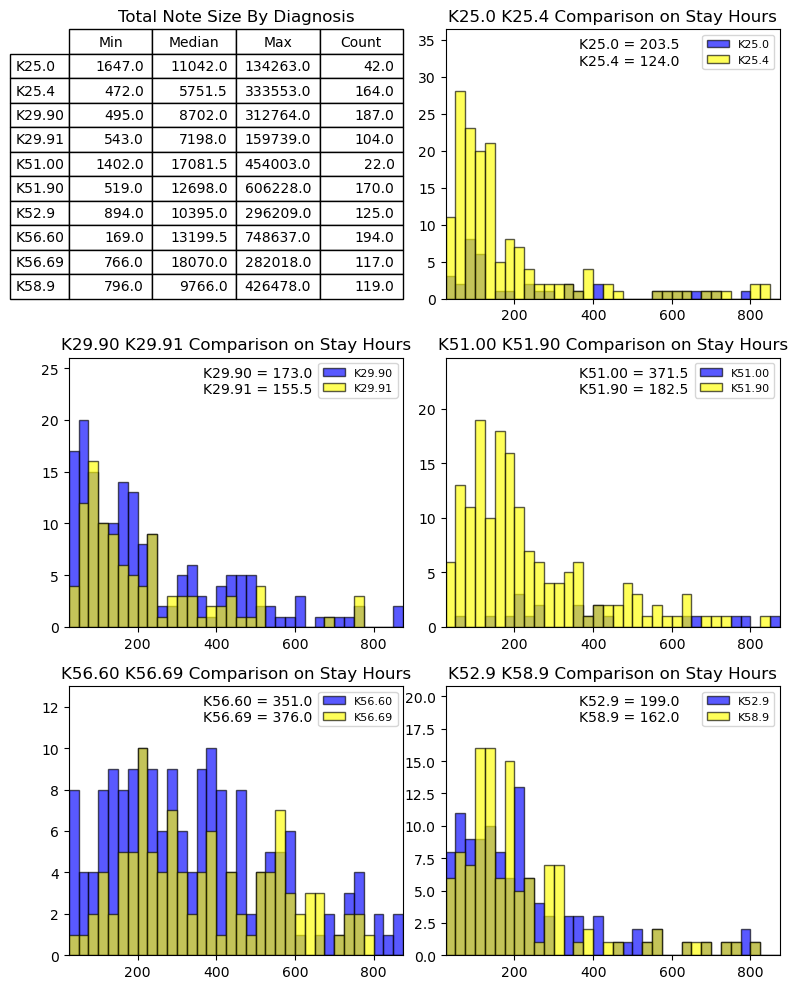

In [186]:
import matplotlib.pyplot as plt
import pandas as pd


figure, axis = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)

bbox = [0, 0, 1, 1]
axis[0,0].axis('tight')
axis[0,0].axis('off')
axis[0,0].set_title('Total Note Size By Diagnosis')
clabels = ['Min', 'Median', 'Max', 'Count']
mpl_table = axis[0,0].table(cellText=lnotes.values, rowLabels=lnotes.index, bbox=bbox, colLabels=clabels)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(10)
mpl_table.scale(4,4)

                          
                          
icd_codes = {'K25.0':'K25.4','K29.90':'K29.91','K51.00':'K51.90', 'K56.60':'K56.69','K52.9':'K58.9'}

abins = range(25,900,25)
kwargs = dict(alpha=0.65, bins=abins)

x_row = 0
x_col = 1

for code_1, code_2 in icd_codes.items():

    xm = intsl_notes.loc[(intsl_notes['primary_icd10_code'].str.contains(code_1)),'stay_hours']
    xs = intsl_notes.loc[(intsl_notes['primary_icd10_code'].str.contains(code_2)),'stay_hours']
    
    atext = code_1 + ' = ' + str(xm.median())
    btext = code_2 + ' = ' + str(xs.median())
    
    axis[x_row,x_col].hist(xm, **kwargs, color='blue', edgecolor='black',label=str(code_1))
    axis[x_row,x_col].hist(xs, **kwargs, color='yellow', edgecolor='black',label=str(code_2))
    xtitle = code_1 + ' ' + code_2 + ' Comparison on Stay Hours'
    axis[x_row,x_col].text(0.40, 0.97, atext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.40, 0.91, btext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].legend(fontsize="8")
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].margins(0,0.30) 
    if x_col == 0:
        x_col += 1
    else:
        x_row += 1
        x_col = 0
plt.show()

<div class="alert alert-block alert-success"><font color="black"><h1><left>Write File with Admission Details and Attached Combined Notes</left></h1></font></div>

In [33]:
path = 'E://Education//DataScience/CCSU-Data-Science/Data-Mining-And-Predictive-Analytics/Data-531/Data/'
intsl_notes.to_parquet(path + 'pd_notes.snappy.parquet',compression='snappy',index=None)  

In [35]:
print('intsl_notes', intsl_notes.shape)
print('spec_intel_amds',spec_intel_amds.shape)

intsl_notes (1244, 20)
spec_intel_amds (1853, 17)


In [8]:
import boto3, os
s3 = boto3.resource('s3')
path = 'E://Education//DataScience/CCSU-Data-Science/Data-Mining-And-Predictive-Analytics/Data-531/Data/'
fname = 'pd_notes.snappy.parquet' 
S3_path = 'MIMIC/Data/' + fname
out_file = path + fname

In [9]:
s3.meta.client.upload_file(out_file, 'depratti-masters-thesis', S3_path)